# PID CONTROLLER PARA MANTER O BAXTER TOCANDO A MESA. OS DADOS OBTIDOS AQUI SÃO USADOS PARA CRIAR UMA LSM QUE COPIE O COMPORTAMENTO DO CONTROLADOR.

# OS VALORES DO PID FORAM OBTIDOS USANDO O METODO DE ziegler nichols.

# fazer:: olhar melhor no ogata para justificar bem o método e referenciar

# GANHOS UTILIZADOS:  PDI_FORCE:  13.5, 33.75, 1.35 ; PDI_RANGE: 10.0, 33.3333333333, 0.75


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 12}

plt.rc('font', **font)

import numpy
import rospy
import baxter_interface
import baxter_control

In [4]:
working_frequency = 100.0


#simulation type
#platform = "gazeboBaxter"
platform = "realBaxter"

trial_number = 0

##--data and video filenames--_AJUSTABLE_0.5cm
input_filename = "XY_movement_square_+0.5cm"
#input_filename = "XY_movement_square_HIGHTABLE3_free"

data_folder = "PID_TESTS"
input_folder = "BaxterArm_VREP_simulation_data/square"
sim_type = "with_PID_0.5cm"
##
limb = "left"
movtimeout = 1.0 #seconds
armspeed = 0.3 #percentage of arm speed
#[S0, S1, E1, W1]: [-0.60048157 -0.75280726  2.09665728  0.24717198] : 0.0
#[S0, S1, E1, W1]: [-0.60068953 -0.76690102  2.10270405  0.25267634] : +0.5cm
#[S0, S1, E1, W1]: [-0.60048157 -0.75280726  2.09665728  0.24717198] : +1cm
#[S0, S1, E1, W1]: [-0.60131329 -0.80917645  2.11977959  0.27020329] : +2cm

[S0, S1, E1, W1]: [-0.60216504 -0.86685359  2.14049506  0.29656434]
[S0, S1, E1, W1]: [-0.60216504 -0.86685359  2.14049506  0.29656434]


<IPython.core.display.Javascript object>


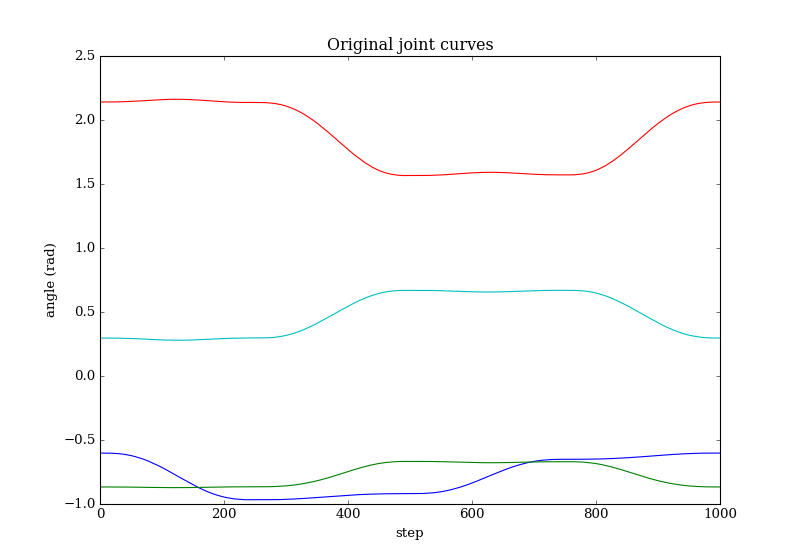

In [5]:
original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...
temp=numpy.load("./"+input_folder+"/"+input_filename+".npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))

joints=numpy.copy(original_joints)


print "[S0, S1, E1, W1]:",joints[0,:]
print "[S0, S1, E1, W1]:",joints[-1,:]

plt.figure(figsize=(10,7))
plt.plot(joints)
plt.title("Original joint curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")
plt.show()

In [6]:
from sensor_msgs.msg import Range

class BaxterRangeSensor():
    def __init__(self):
        self.distance = 0
        sensor_name = "/robot/range/left_hand_range/state"
        self.__left_sensor  = rospy.Subscriber(sensor_name,Range, callback=self.__sensorCallback,queue_size=1)

    def __sensorCallback(self,msg,):
        self.distance = msg.range

In [7]:
# INITIAL JOINT ANGLES [s0,s1,e0,e1,w0,w1,w2]   (comanded joints [s0,s1,e1,w1])
print joints[0,:]
initial_joint_angles=numpy.array([joints[0,0],joints[0,1],0.0,joints[0,2],0.0,joints[0,3],0.0]) #in degrees!
#print "rostopic pub /robot/limb/left/joint_command baxter_core_msgs/JointCommand \"{mode: 1, command: "+str((initial_joint_angles[[4,5,6,2,3,0,1]]*numpy.pi/180).tolist())+", names: ['left_w0', 'left_w1', 'left_w2', 'left_e0', 'left_e1', 'left_s0', 'left_s1']}\" -r 100"
print "rostopic pub /robot/limb/left/joint_command baxter_core_msgs/JointCommand \"{mode: 1, command: "+str((initial_joint_angles[[4,5,6,2,3,0,1]]).tolist())+", names: ['left_w0', 'left_w1', 'left_w2', 'left_e0', 'left_e1', 'left_s0', 'left_s1']}\" -r 100"

[-0.60216504 -0.86685359  2.14049506  0.29656434]
rostopic pub /robot/limb/left/joint_command baxter_core_msgs/JointCommand "{mode: 1, command: [0.0, 0.29656434059143066, 0.0, 0.0, 2.1404950618743896, -0.6021650433540344, -0.8668535947799683], names: ['left_w0', 'left_w1', 'left_w2', 'left_e0', 'left_e1', 'left_s0', 'left_s1']}" -r 100


In [8]:
rospy.init_node("arm_mov", anonymous=True)

In [9]:
#initialize arms and settings

arm = baxter_interface.Limb(limb)
arm.set_command_timeout(movtimeout)
arm.set_joint_position_speed(armspeed)

#head = baxter_interface.Head()
#head.set_pan(-0.3, speed=0.30, timeout=1.5)

In [10]:
range_sensor = BaxterRangeSensor()

In [11]:
print range_sensor.distance

0.157000005245


In [14]:
#moves the arm to the initial position
joint_names = ['left_s0','left_s1','left_e1','left_w1','left_w0','left_w2','left_e0']
joint_values = numpy.insert(joints[0],4,[0.0,0.0,0.0])
limb_joints = dict(zip(joint_names, joint_values))
print "command: ",limb_joints
arm.move_to_joint_positions(limb_joints, timeout=0.5, threshold=0.003)

joint_angles = arm.joint_angles()
joint_endpoint = arm.endpoint_pose()
print "read:" ,joint_angles,joint_endpoint

command:  {'left_w0': 0.0, 'left_w1': 0.29656434059143066, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1404950618743896, 'left_s0': -0.60216504335403442, 'left_s1': -0.86685359477996826}
read: {'left_w0': -0.0023009711818281204, 'left_w1': 0.2945243112739994, 'left_w2': 0.0019174759848567672, 'left_e0': 0.0019174759848567672, 'left_e1': 2.1379857231152952, 'left_s0': -0.6024709544419963, 'left_s1': -0.864781669170402} {'position': Point(x=0.5165522548594768, y=0.34293798434614103, z=-0.12433774071854112), 'orientation': Quaternion(x=-0.09208415396684282, y=0.9957448382953381, z=0.0009760513807670462, w=0.003431168912148267)}


In [15]:
print joint_endpoint['position'][:]
print joint_endpoint['orientation'][:]


(0.5165522548594768, 0.34293798434614103, -0.12433774071854112)
(-0.09208415396684282, 0.9957448382953381, 0.0009760513807670462, 0.003431168912148267)


In [87]:
print arm.endpoint_velocity()['linear'][:]
print arm.endpoint_effort()['torque'][:]

print arm.endpoint_effort()['force'][:]

(0.00041548855450357244, -0.009679868745743924, 0.0015764761753604558)
(-1.2840123176574707, 0.186179056763649, -0.10252682119607925)
(0.5870466828346252, 1.1369675397872925, 1.3763489723205566)


In [16]:
trial_number = 0
total_trials = 100

TF = 20*0.04
KpF = 13.5
KiF = (KpF*2.0)/TF
KdF = (KpF*TF)/8
print KpF,KiF,KdF

TR = 20*0.03
KpR = 10.0
KiR = KpR*2/TR
KdR = KpR*TR/8
print KpR,KiR,KdR


R_target = 15.7
F_target = -2.0

N = 10

for trial_number in range(75,total_trials):

    ##FORCE PID CONTROLLER
    pidF = baxter_control.PID()
    pidF.set_kp(KpF)
    pidF.set_ki(KiF)
    pidF.set_kd(KdF)

    ##RANGE PID CONTROLLER
    pidR = baxter_control.PID()
    pidR.set_kp(KpR)
    pidR.set_ki(KiR)
    pidR.set_kd(KdR)
    
    joint_values = numpy.insert(joints[0],4,[0.0,0.0,0.0])
    limb_joints = dict(zip(joint_names, joint_values))
    print "command: ",limb_joints
    arm.move_to_joint_positions(limb_joints, timeout=10.5, threshold=0.003)

    force_N = numpy.zeros(N)
    range_N = numpy.zeros(N)
    for i in range(N):
        force_N[i] = numpy.clip(arm.endpoint_effort()['force'][2],-10,1)
        range_N[i] = range_sensor.distance
        rospy.sleep(0.01)
    
    angles_from_robot = []
    position_from_robot = []
    orientation_from_robot = []
    endpoint_velocity = []
    endpoint_torque = []
    endpoint_force = []
    ir_sensor = []
    pidF_hist = []
    pidR_hist = []
    controller_hist = []
    Zforce_hist = []
    
    s1_delta = 0.
    e1_delta = 0.
    w1_delta = 0.

    s1_inc = -0.001409/4
    e1_inc = 0.00057/4
    w1_inc = 0.00057/4
    
    for i in range(len(joints)):

        next_joints = numpy.copy(joints[i])
        
        force_N = numpy.delete(numpy.append(force_N,numpy.clip(arm.endpoint_effort()['force'][2],-10,1)),0)
        curr_z_force = numpy.mean(force_N)
        
        range_N = numpy.delete(numpy.append(range_N,range_sensor.distance),0)
        curr_z_range = numpy.clip(numpy.mean(range_N)*100,15.,20.)        
        
        pidF_u = pidF.compute_output(F_target-curr_z_force)     
        pidR_u = pidR.compute_output(R_target-curr_z_range)
        pid_K = numpy.clip(pidF_u+pidR_u,-95,40)
        
        s1_delta = pid_K*s1_inc
        e1_delta = pid_K*e1_inc
        w1_delta = pid_K*w1_inc
        
        next_joints[1] = next_joints[1] + s1_delta 
        next_joints[2] = next_joints[2] + e1_delta
        next_joints[3] = next_joints[3] + w1_delta


        joint_values = numpy.insert(next_joints,4,[0.0,0.0,0.0])
        limb_joints = dict(zip(joint_names, joint_values))
        #print "PID:"+str(pid_u)+"force:"+str(curr_z_force)
        
        for _ in range(3):
            arm.set_joint_positions(limb_joints)
            rospy.sleep(0.01)
            
        controller_hist.append([s1_delta, e1_delta, w1_delta])
        pidF_hist.append(pidF_u)
        pidR_hist.append(pidR_u)
        angles_from_robot.append(arm.joint_angles().values())
        joint_endpoint = arm.endpoint_pose()
        endpoint_velocity.append(arm.endpoint_velocity()['linear'][:])    
        position_from_robot.append(joint_endpoint['position'][:])
        orientation_from_robot.append(joint_endpoint['orientation'][:])
        endpoint_torque.append(arm.endpoint_effort()['torque'][:])
        endpoint_force.append(arm.endpoint_effort()['force'][:])
        ir_sensor.append(curr_z_range)
        Zforce_hist.append(curr_z_force)
        
    print "DONE!"

    joint_names = ['left_s0','left_s1','left_e1','left_w1','left_w0','left_w2','left_e0']
    joint_values = numpy.insert(joints[0],4,[0.0,0.0,0.0])
    limb_joints = dict(zip(joint_names, joint_values))
    arm.move_to_joint_positions(limb_joints, timeout=3.0, threshold=0.003)

    numpy.save(data_folder+"/"+sim_type+"ANGLES_trial"+str(trial_number)+".npy",angles_from_robot)
    numpy.save(data_folder+"/"+sim_type+"POSITION_trial"+str(trial_number)+".npy",position_from_robot)
    numpy.save(data_folder+"/"+sim_type+"VELOCITY_trial"+str(trial_number)+".npy",endpoint_velocity)
    numpy.save(data_folder+"/"+sim_type+"ORIENTATION_trial"+str(trial_number)+".npy",orientation_from_robot)
    numpy.save(data_folder+"/"+sim_type+"TORQUE_trial"+str(trial_number)+".npy",endpoint_torque)
    numpy.save(data_folder+"/"+sim_type+"FORCE_trial"+str(trial_number)+".npy",endpoint_force)
    numpy.save(data_folder+"/"+sim_type+"CONTROLLER_trial"+str(trial_number)+".npy",controller_hist)
    
    numpy.save(data_folder+"/"+sim_type+"IRange_trial"+str(trial_number)+".npy",ir_sensor)
    numpy.save(data_folder+"/"+sim_type+"Zforce_trial"+str(trial_number)+".npy",Zforce_hist)
    numpy.save(data_folder+"/"+sim_type+"PID_Force_hist_trial"+str(trial_number)+".npy",pidF_hist)
    numpy.save(data_folder+"/"+sim_type+"PID_Range_hist_trial"+str(trial_number)+".npy",pidR_hist)
    
    
    

13.5 33.75 1.35
10.0 33.3333333333 0.75
command:  {'left_w0': 0.0, 'left_w1': 0.29656434059143066, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1404950618743896, 'left_s0': -0.60216504335403442, 'left_s1': -0.86685359477996826}
DONE!
command:  {'left_w0': 0.0, 'left_w1': 0.29656434059143066, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1404950618743896, 'left_s0': -0.60216504335403442, 'left_s1': -0.86685359477996826}
DONE!
command:  {'left_w0': 0.0, 'left_w1': 0.29656434059143066, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1404950618743896, 'left_s0': -0.60216504335403442, 'left_s1': -0.86685359477996826}
DONE!
command:  {'left_w0': 0.0, 'left_w1': 0.29656434059143066, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1404950618743896, 'left_s0': -0.60216504335403442, 'left_s1': -0.86685359477996826}
DONE!
command:  {'left_w0': 0.0, 'left_w1': 0.29656434059143066, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1404950618743896, 'left_s0': -0.60216504335403442, 'left_s1': -0.866853594779968

<IPython.core.display.Javascript object>


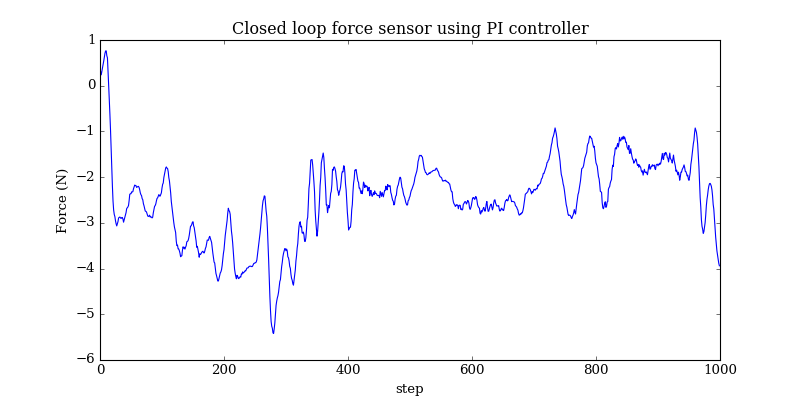

<IPython.core.display.Javascript object>


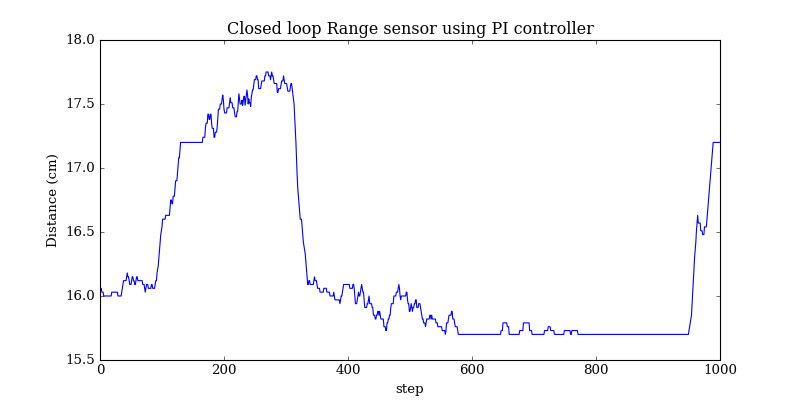

<IPython.core.display.Javascript object>


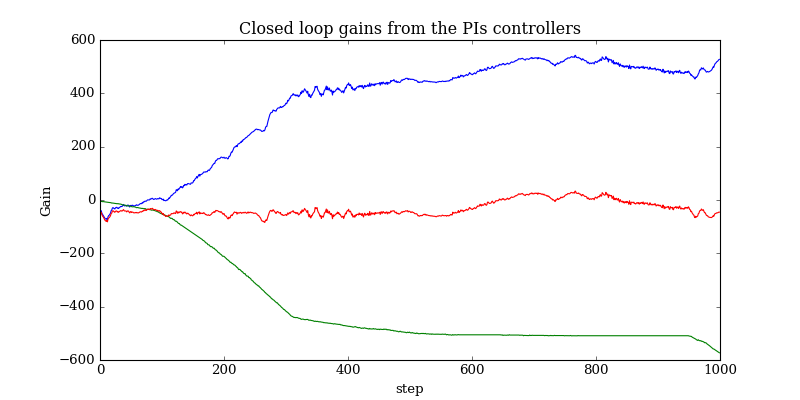

In [134]:
plt.figure(figsize=(10,5))
plt.plot(Zforce_hist)
plt.title("Closed loop force sensor using PI controller")
plt.ylabel("Force (N)")
plt.xlabel("step")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ir_sensor)
plt.title("Closed loop Range sensor using PI controller")
plt.ylabel("Distance (cm)")
plt.xlabel("step")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(pidF_hist)
plt.plot(pidR_hist)
plt.plot(numpy.array(pidF_hist)+numpy.array(pidR_hist))
plt.title("Closed loop gains from the PIs controllers")
plt.ylabel("Gain")
plt.xlabel("step")
plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(pidR_hist)
# plt.title("Closed loop gains from the PIs controllers")
# plt.ylabel("Gain")
# plt.xlabel("step")
# plt.show()


In [58]:
ir_sensor[800]

0.15700000524520874

In [81]:
print pid_hist

[-70.0, -70.0, -70.0, -70.0, -70.0, -70.0]


<IPython.core.display.Javascript object>


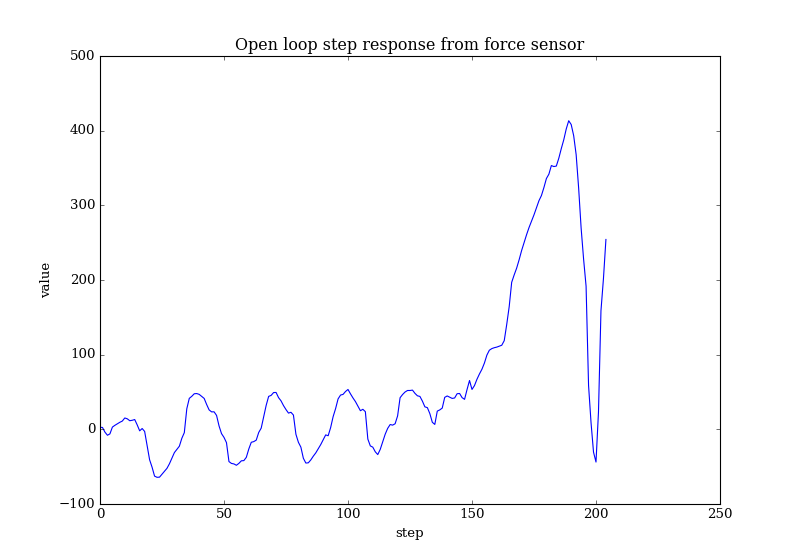

In [35]:
plt.figure(figsize=(10,7))
plt.plot(pid_hist)
plt.title("Open loop step response from force sensor")
plt.ylabel("value")
plt.xlabel("step")
plt.show()

<IPython.core.display.Javascript object>


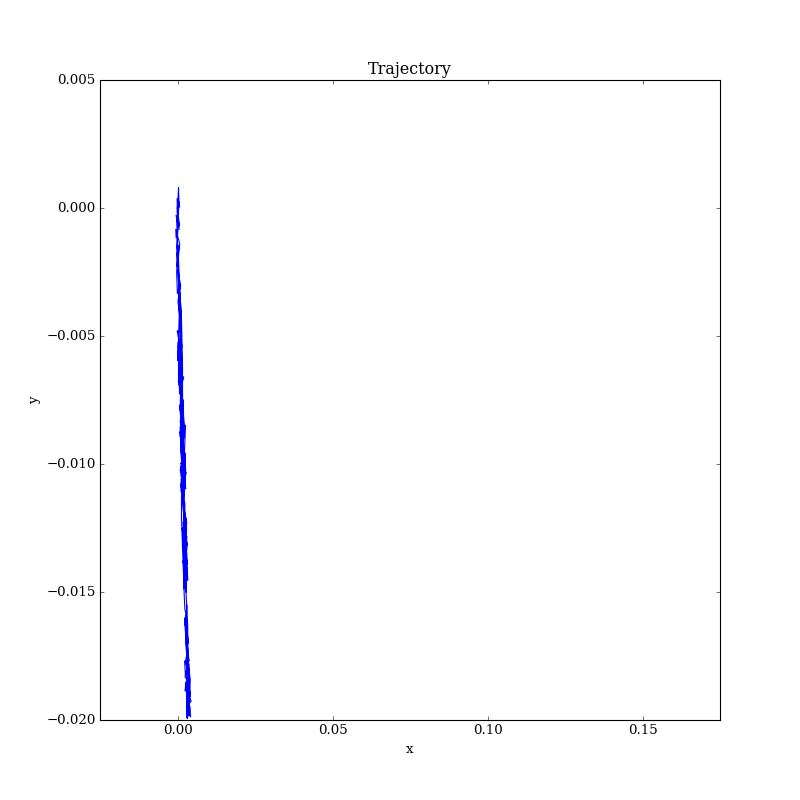

<IPython.core.display.Javascript object>


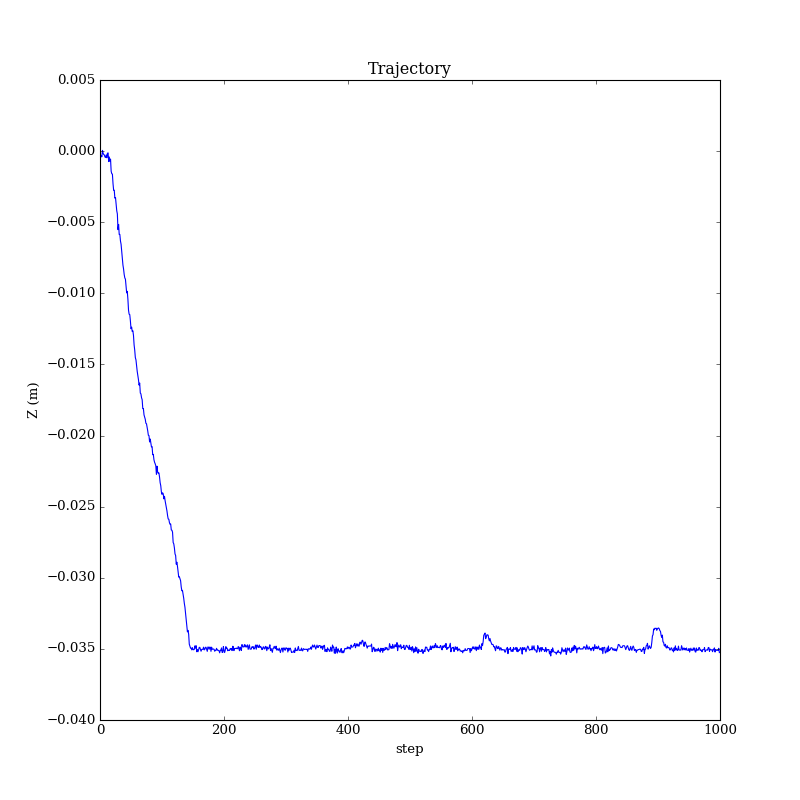

In [25]:

enp = numpy.array(position_from_robot)


y = numpy.copy(enp[:,0])
x = numpy.copy(enp[:,1])
x = -(x-x[0])
y = (y-y[0])
z = numpy.copy(enp[:,2])

robot_endpoints = numpy.array([x,y,z]).T

plt.figure(figsize=(10,10))
plt.plot(robot_endpoints[:,0],robot_endpoints[:,1])
plt.title("Trajectory")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(-0.025,0.175)
plt.xlim(-0.025,0.175)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(robot_endpoints[:,2]-robot_endpoints[0,2])
plt.title("Trajectory")
plt.ylabel("Z (m)")
plt.xlabel("step")
plt.show()

<IPython.core.display.Javascript object>


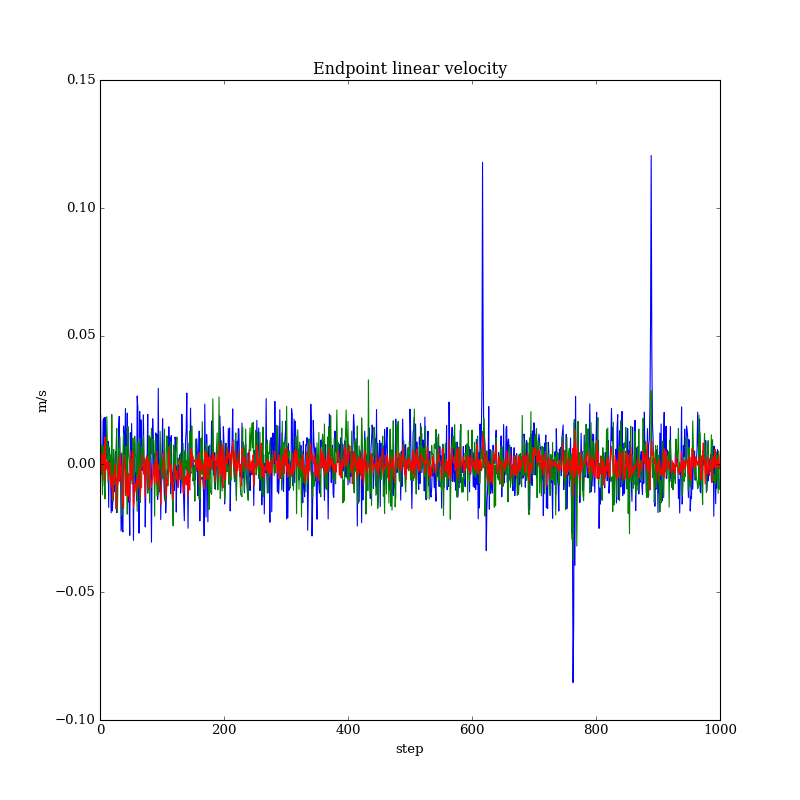

In [26]:
plt.figure(figsize=(10,10))
plt.plot(endpoint_velocity)
plt.title("Endpoint linear velocity")
plt.ylabel("m/s")
plt.xlabel("step")
plt.show()




<IPython.core.display.Javascript object>


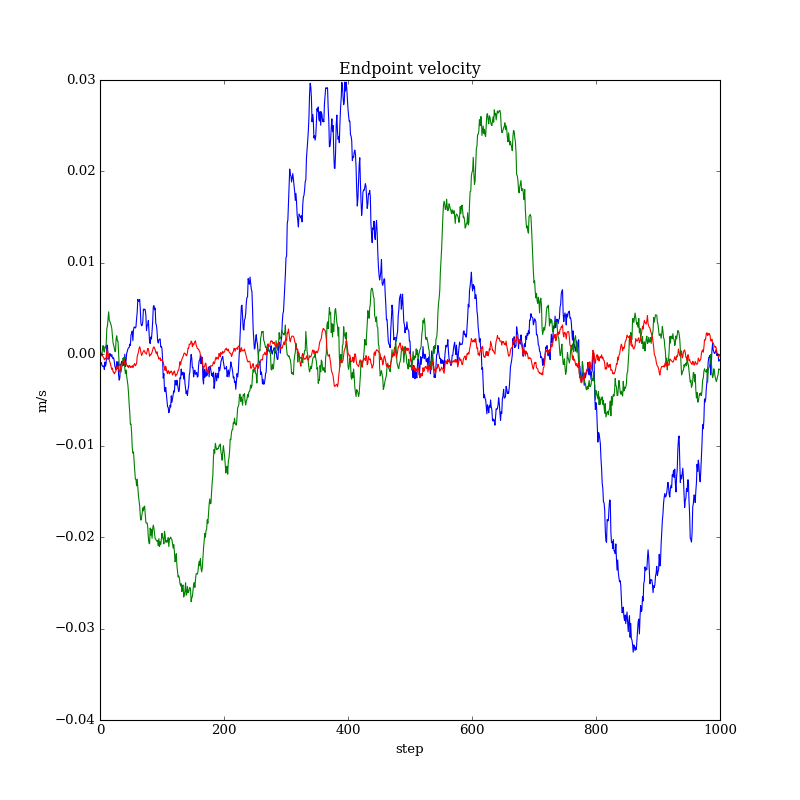

In [669]:
endpoint_velocity =  numpy.array(endpoint_velocity)
N = 20
velocity_x_filtered = numpy.convolve(endpoint_velocity[:,0], numpy.ones((N,))/N, mode='same')
velocity_y_filtered = numpy.convolve(endpoint_velocity[:,1], numpy.ones((N,))/N, mode='same')
velocity_z_filtered = numpy.convolve(endpoint_velocity[:,2], numpy.ones((N,))/N, mode='same')


plt.figure(figsize=(10,10))
plt.plot(velocity_x_filtered)
plt.plot(velocity_y_filtered)
plt.plot(velocity_z_filtered)
plt.title("Endpoint velocity")
plt.ylabel("m/s")
plt.xlabel("step")
plt.show()

In [134]:
# endpoint_torque =  numpy.array(endpoint_torque)
# N = 5
# torque_x_filtered = numpy.convolve(endpoint_torque[:,0], numpy.ones((N,))/N, mode='same')
# torque_y_filtered = numpy.convolve(endpoint_torque[:,1], numpy.ones((N,))/N, mode='same')
# torque_z_filtered = numpy.convolve(endpoint_torque[:,2], numpy.ones((N,))/N, mode='same')


# plt.figure(figsize=(10,10))
# plt.plot(torque_x_filtered)
# plt.plot(torque_y_filtered)
# plt.plot(torque_z_filtered)
# plt.title("Endpoint torque")
# plt.ylabel("N.m")
# plt.xlabel("step")
# plt.show()



# plt.figure(figsize=(10,10))
# plt.plot(endpoint_torque[:,2])
# plt.title("Endpoint torque Z")
# plt.ylabel("m/s")
# plt.xlabel("step")
# plt.show()


<IPython.core.display.Javascript object>


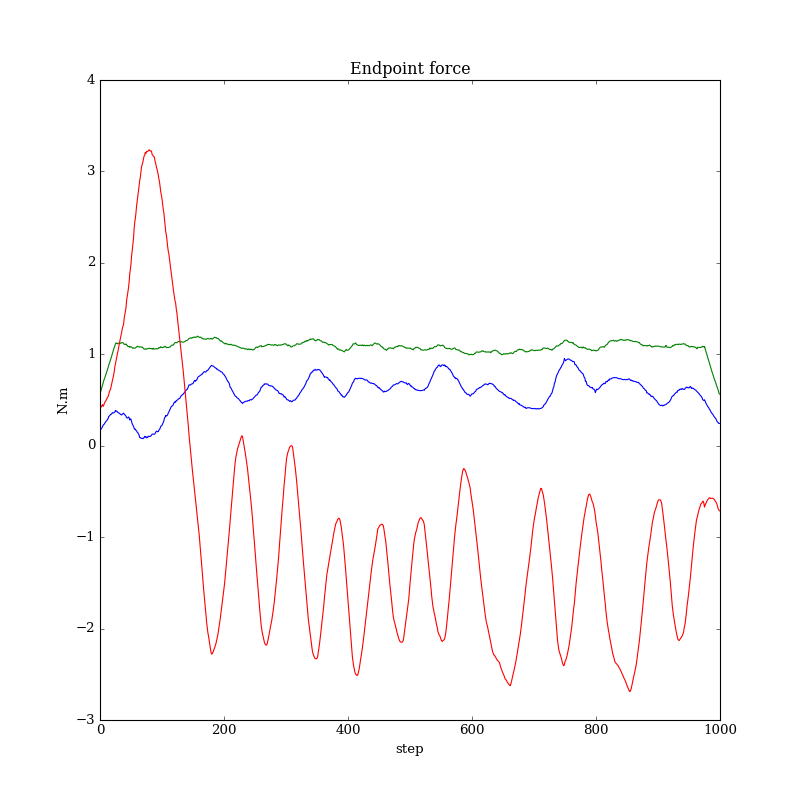

<IPython.core.display.Javascript object>


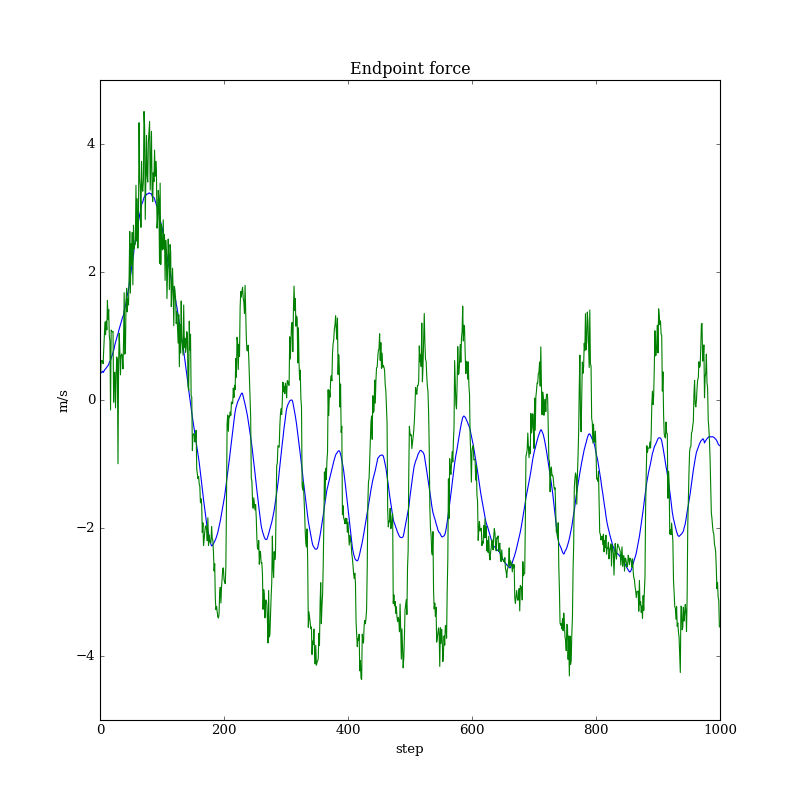

In [34]:
endpoint_force =  numpy.array(endpoint_force)
N = 50
force_x_filtered = numpy.convolve(endpoint_force[:,0], numpy.ones((N,))/N, mode='same')
force_y_filtered = numpy.convolve(endpoint_force[:,1], numpy.ones((N,))/N, mode='same')
force_z_filtered = numpy.convolve(endpoint_force[:,2], numpy.ones((N,))/N, mode='same')

plt.figure(figsize=(10,10))
plt.plot(force_x_filtered)
plt.plot(force_y_filtered)
plt.plot(force_z_filtered)
plt.title("Endpoint force")
plt.ylabel("N.m")
plt.xlabel("step")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(force_z_filtered)

plt.plot(endpoint_force[:,2])
plt.title("Endpoint force")
plt.ylabel("m/s")
plt.xlabel("step")
plt.show()

(-0.09253093376659226, 0.9956815120266729, 0.0004299767727493937, -0.0074945329765102355)
(-0.09201335315037536, 0.9955621134522451, -0.00048804417428140135, -0.019732787775861096)
(-0.09144534358961702, 0.9956918524714053, -4.437508522628644e-05, -0.015345425660105601)


<IPython.core.display.Javascript object>


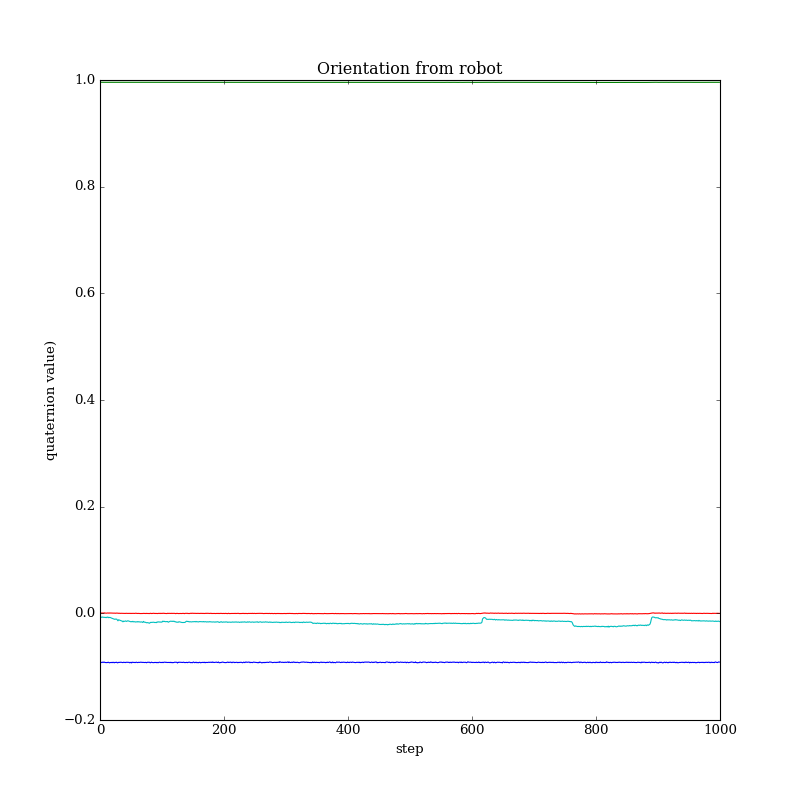

In [28]:
print orientation_from_robot[0]
print orientation_from_robot[500]
print orientation_from_robot[-1]


plt.figure(figsize=(10,10))
plt.plot(orientation_from_robot)
plt.title("Orientation from robot")
plt.ylabel("quaternion value)")
plt.xlabel("step")
plt.show()

<IPython.core.display.Javascript object>


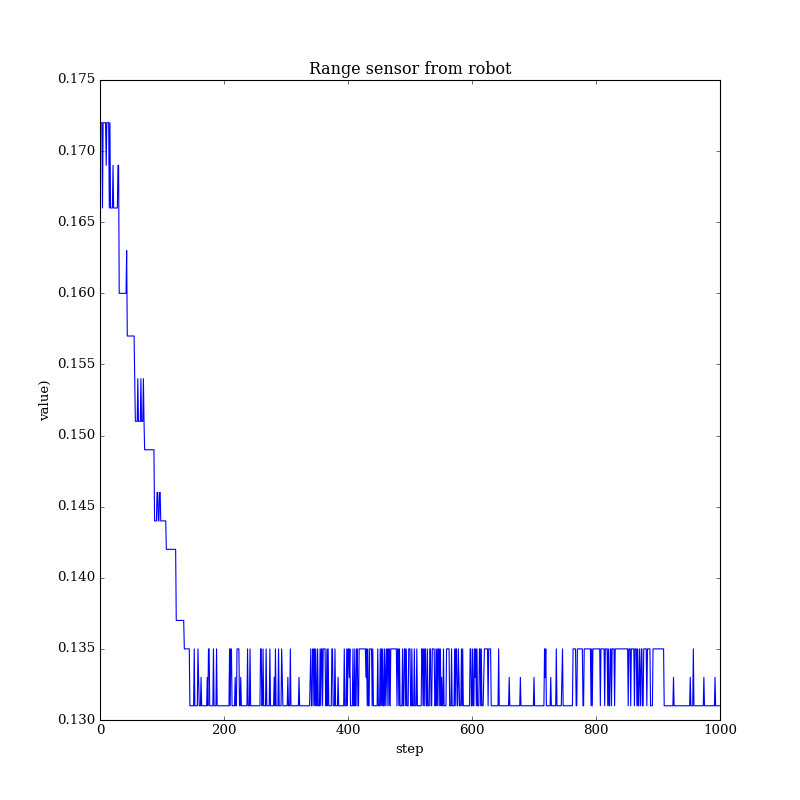

In [29]:
plt.figure(figsize=(10,10))
plt.plot(ir_sensor)
plt.title("Range sensor from robot")
plt.ylabel("value)")
plt.xlabel("step")
plt.show()

<IPython.core.display.Javascript object>


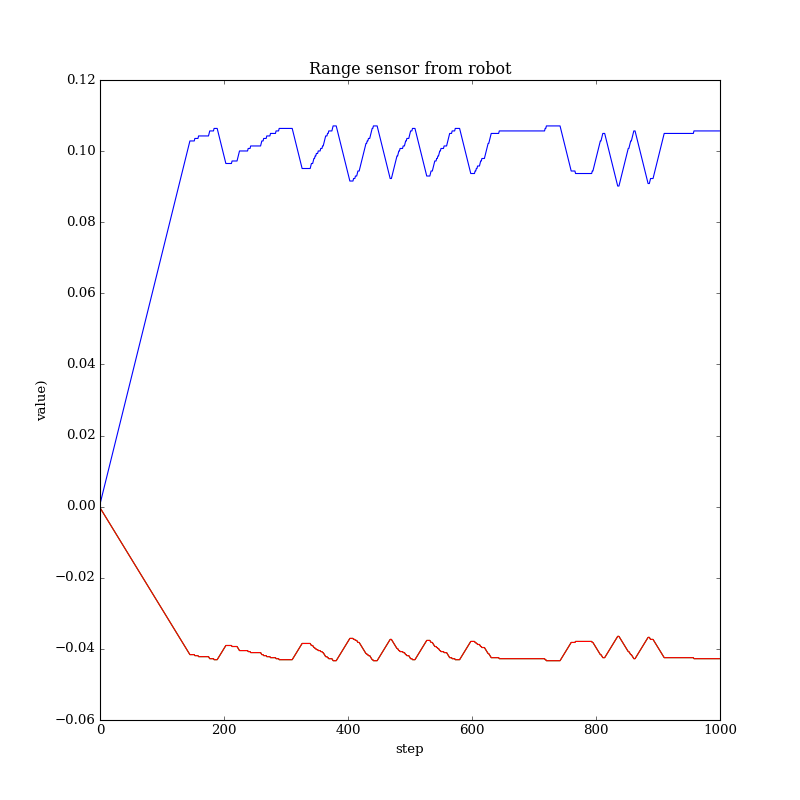

In [30]:
plt.figure(figsize=(10,10))
plt.plot(controller_hist)
plt.title("Range sensor from robot")
plt.ylabel("value)")
plt.xlabel("step")
plt.show()

<IPython.core.display.Javascript object>


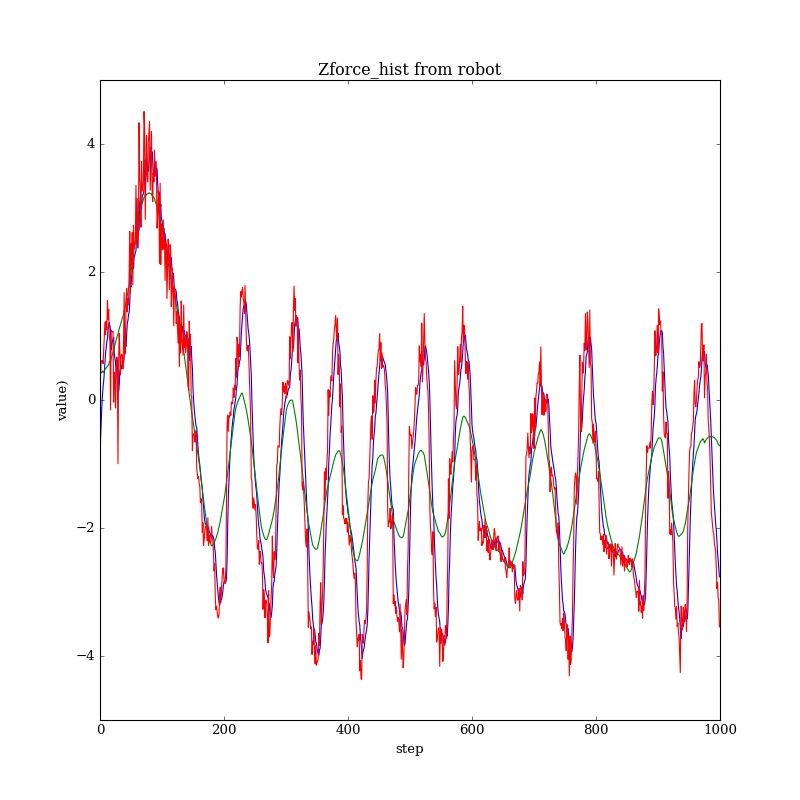

In [35]:
plt.figure(figsize=(10,10))
plt.plot(Zforce_hist)
plt.plot(force_z_filtered)
plt.plot(endpoint_force[:,2])
plt.title("Zforce_hist from robot")
plt.ylabel("value)")
plt.xlabel("step")
plt.show()